<a href="https://colab.research.google.com/github/AshHydroCoder/LULC-Change/blob/main/LULC_Change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install rasterio numpy matplotlib pandas
!pip install pdfplumber

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 74.0 MB/s eta 0:00:00


In [ ]:
#Imports
import os
import zipfile
import rasterio
import numpy as np
import matplotlib.pyplot as plt
LULC_Folder = '/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal'
OUT = '/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/'

In [ ]:
#Extract tif files
land_cover_data = {}
for zip_file in os.listdir(LULC_Folder):
    if zip_file.endswith('.zip'):
        zip_path = os.path.join(LULC_Folder, zip_file)
        year = zip_file.split('_')[-1][:-4]
        with zipfile.ZipFile(zip_path, 'r') as zipf:
            for file in zipf.namelist():
              if file.endswith(".tif"):
                zipf.extract(file,OUT)
                extracted_file = os.path.join(OUT,file)
                print(extracted_file)
                new_file = os.path.join(OUT,f"land_cover_{year}.tif")
                os.rename(extracted_file, new_file)
                with rasterio.open(new_file) as src:
                  land_cover_data[year] = src.read(1)

/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/nlcms_2000/data/lc2000.tif
/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/nlcms_2001/data/lc2001.tif
/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/nlcms_2002/data/lc2002.tif
/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/nlcms_2004/data/lc2004.tif
/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/nlcms_2005/data/lc2005.tif
/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/nlcms_2007/data/lc2007.tif
/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/nlcms_2008/data/lc2008.tif
/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/nlcms_2006/data/lc2006.tif
/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/nlcms_2010/data/lc2010.tif
/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/nlcms_2009/data/lc2009.tif
/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/nlcms_2011/data/lc2011.tif
/content/drive/MyDrive/Thesis/REGRID/LULC D

In [ ]:
land_cover_data = {}
for tif in os.listdir(OUT):
  if tif.endswith(".tif"):
    year = tif.split("_")[-1][:-4]
    with rasterio.open(os.path.join(OUT,tif)) as src:
      land_cover_data[year] = src.read(1)
years = sorted(land_cover_data.keys())


In [5]:
import pdfplumber
pdf_path = '/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Data Description.pdf'
land_cover_names = {}
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        lines = text.split('\n')
        for line in lines[2:]:
          parts = line.split()
          grid_value = int(parts[-1])
          class_name = ' '.join(parts[:-1])
          land_cover_names[grid_value] = class_name
print(land_cover_names)

{1: 'Waterbody', 2: 'Glacier', 3: 'Snow', 4: 'Forest', 5: 'Riverbed', 6: 'Built-up area', 7: 'Cropland', 8: 'Bare soil', 9: 'Bare rock', 10: 'Grassland', 11: 'Other wooded land'}


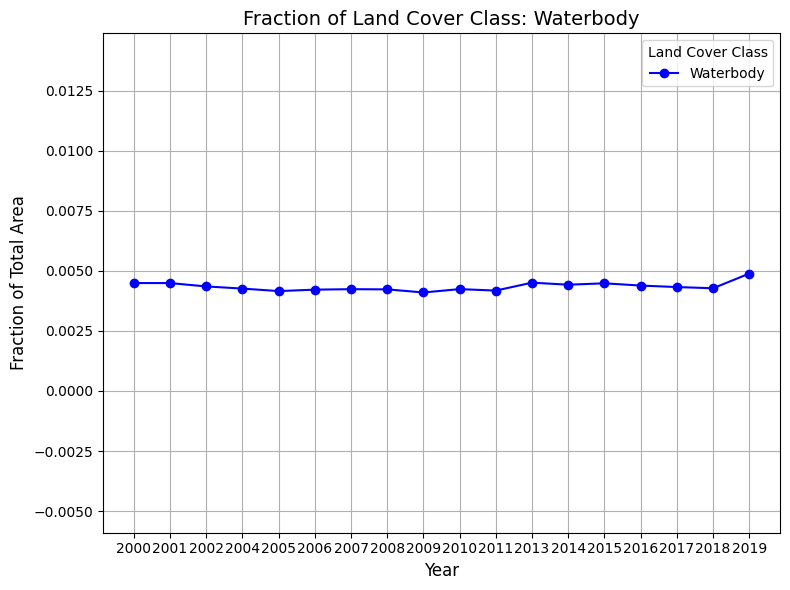

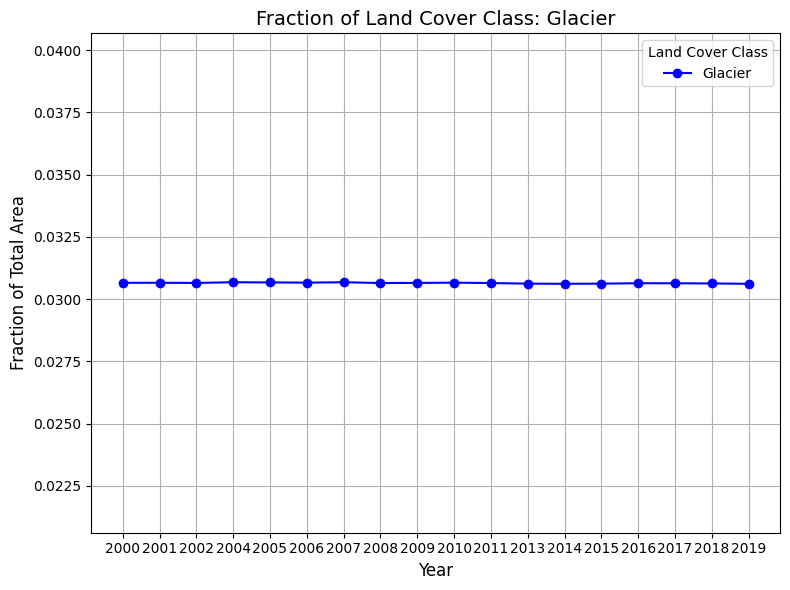

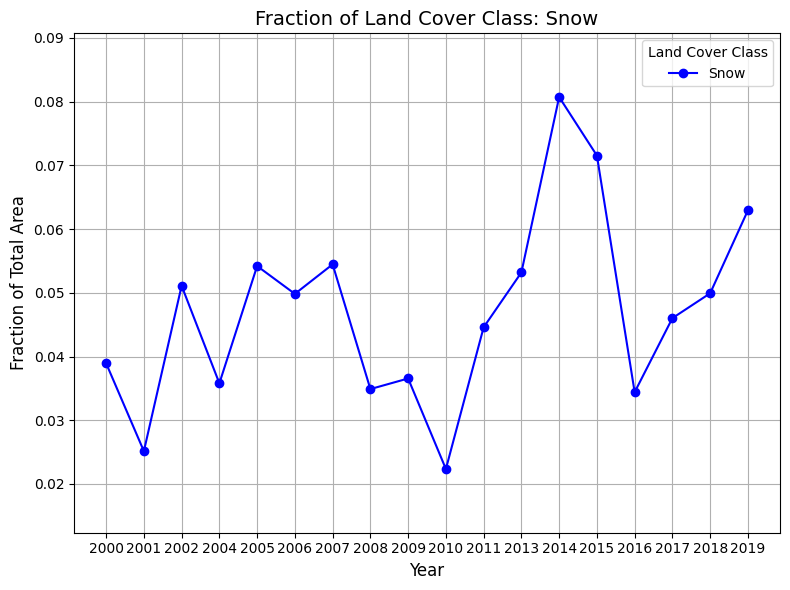

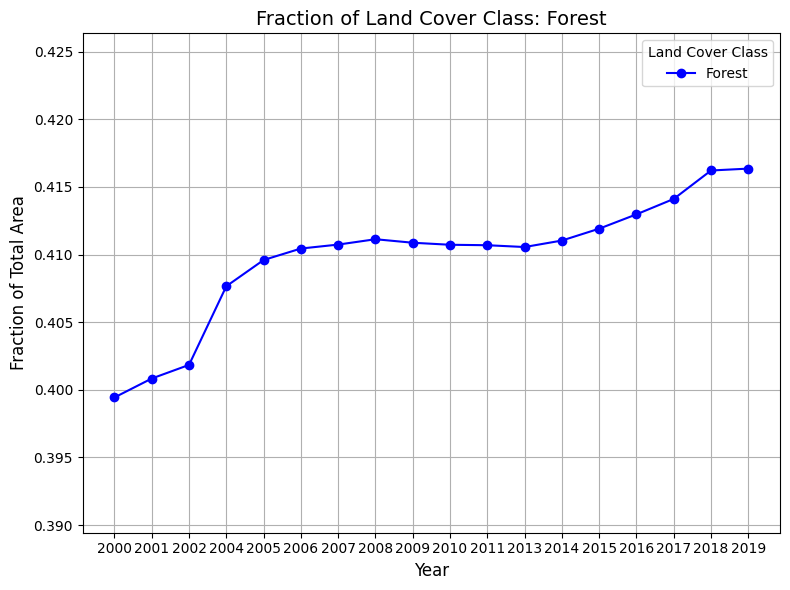

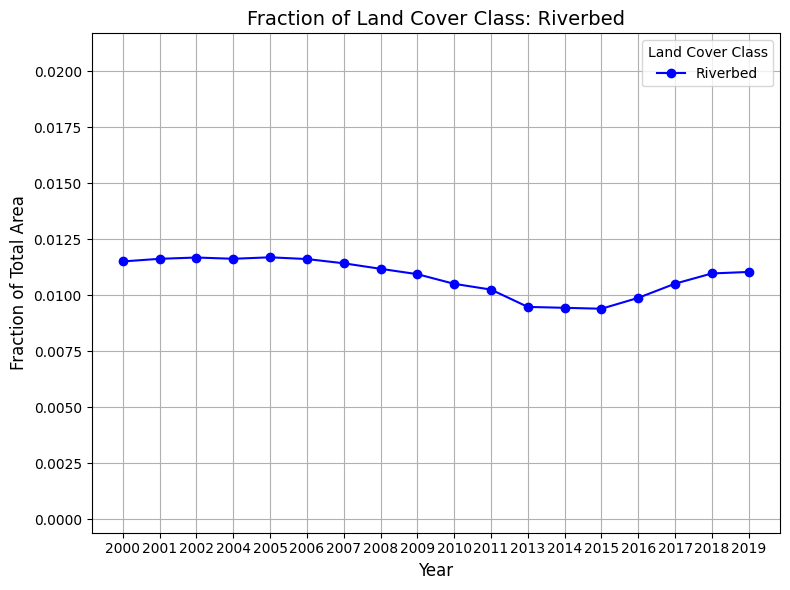

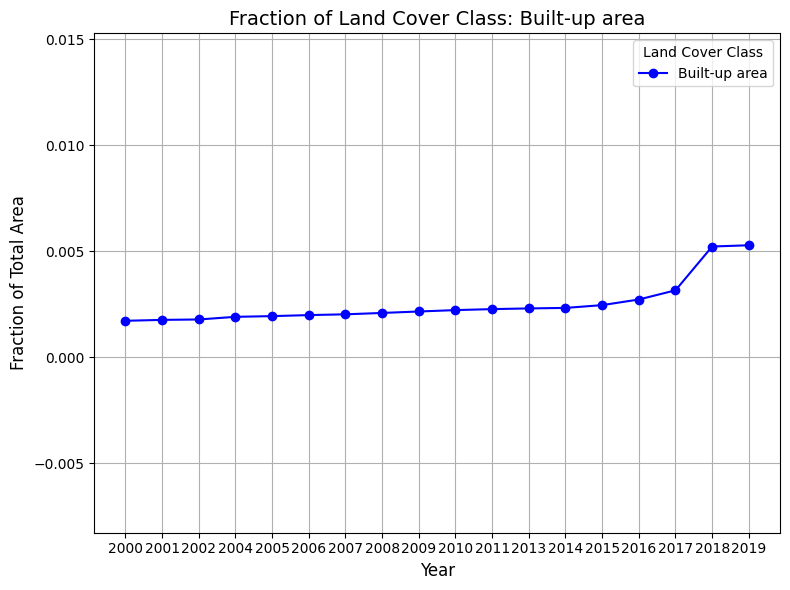

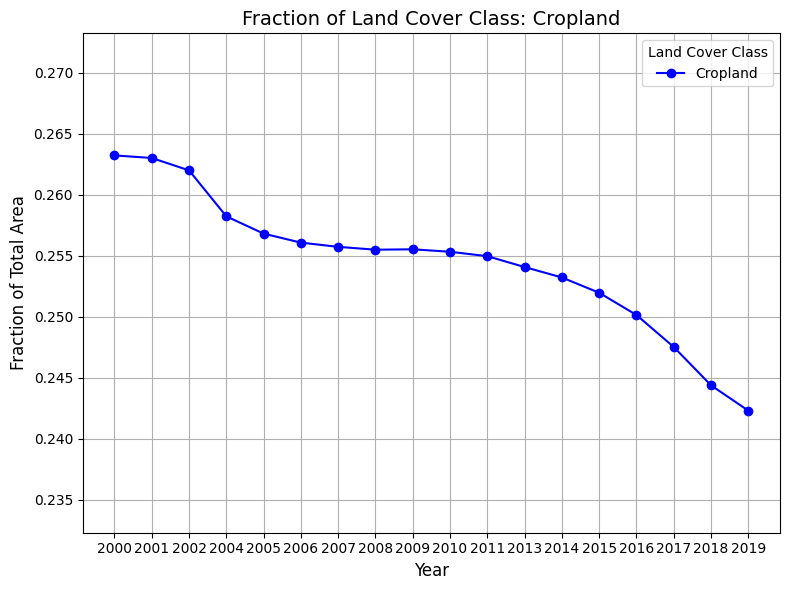

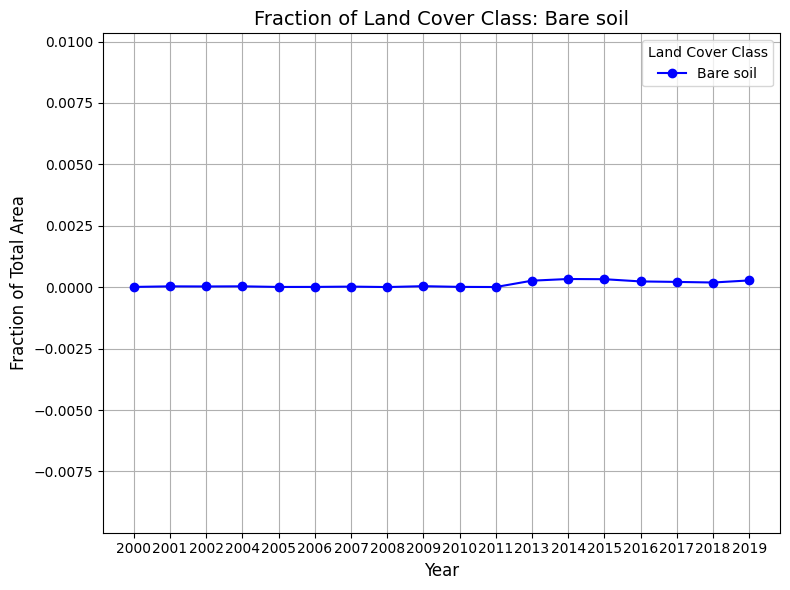

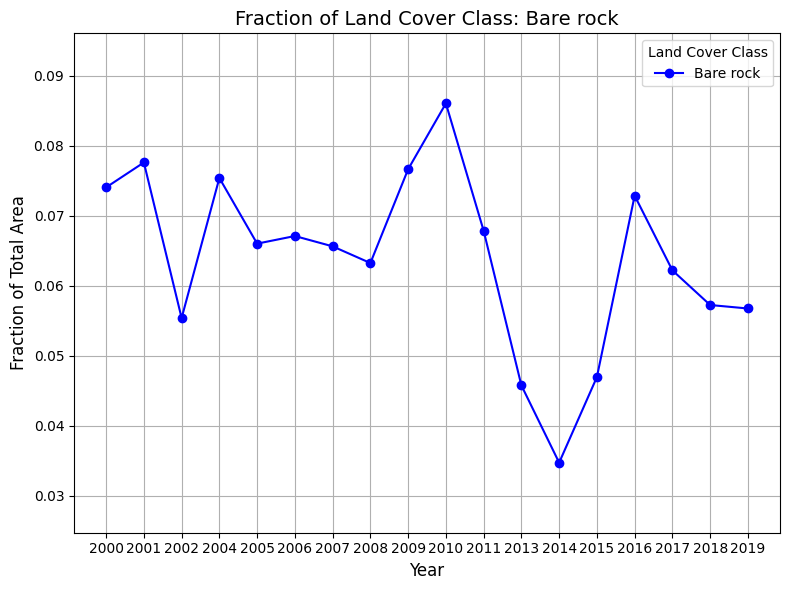

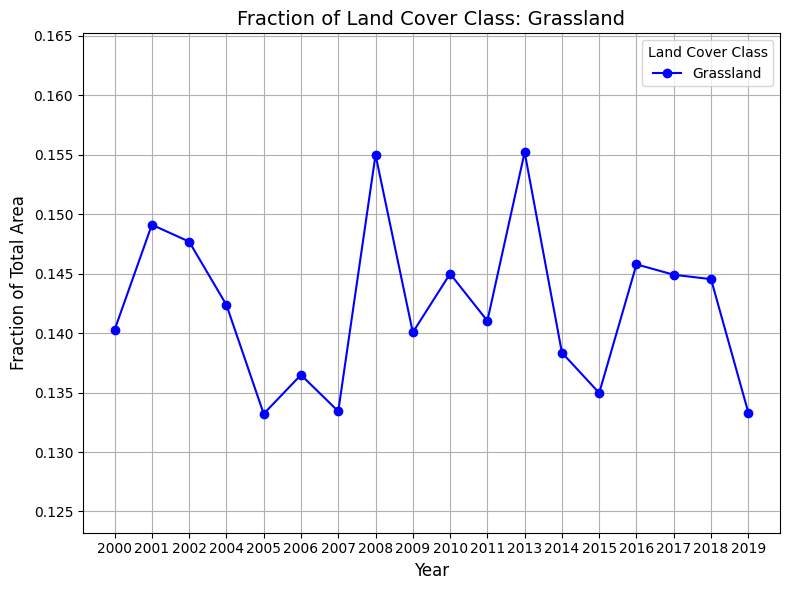

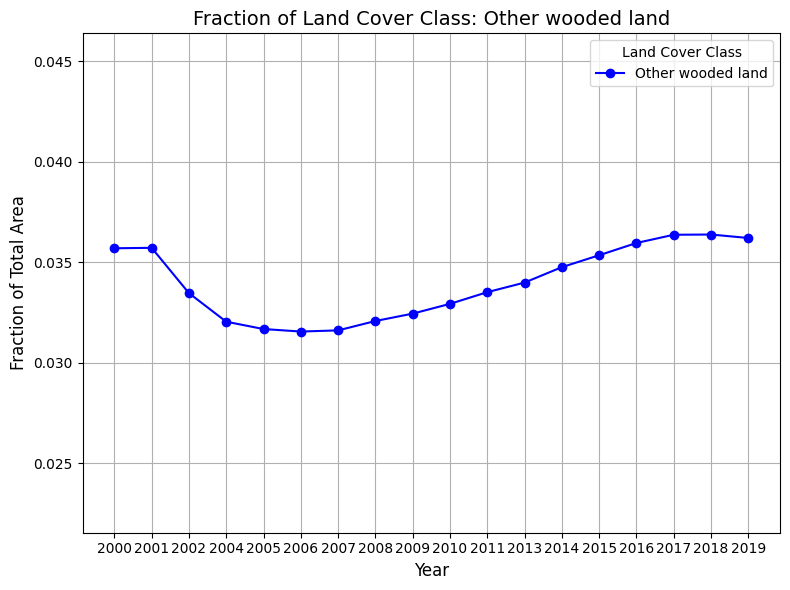

In [ ]:
land_cover_classes = np.arange(1, 12)
fractions = {lc_class: [] for lc_class in land_cover_classes}
for year in years:
    data = land_cover_data[year]
    valid = data[data > 0]  # Exclude pixels with value 0 (no data)
    total_pixels = valid.size  # Total number of pixels in the raster
    for lc_class in land_cover_classes:
        class_pixel_count = np.sum(data == lc_class)
        fraction = class_pixel_count / total_pixels  # Calculate fraction
        fractions[lc_class].append(fraction)

# Step 3: Plot individual graphs for each land cover class
for lc_class in land_cover_classes:
    plt.figure(figsize=(8, 6))

    # Get fraction values for the class
    fractions_class = fractions[lc_class]
    max_fraction = max(fractions_class)
    min_fraction = min(fractions_class)

    # Plot the graph
    plt.plot(years, fractions_class, marker='o', linestyle='-', color='b')
    class_name = land_cover_names.get(lc_class, f"Class {lc_class}")  # Use name if available
    plt.title(f"Fraction of Land Cover Class: {class_name}", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Fraction of Total Area", fontsize=12)
    plt.ylim(min_fraction - 0.01, max_fraction + 0.01)  # Dynamic range
    plt.grid(True)
    plt.legend([class_name], title="Land Cover Class")
    plt.tight_layout()
    plt.show()

/content/drive/MyDrive/Thesis/RESULT/LANDUSE/Cluster_5


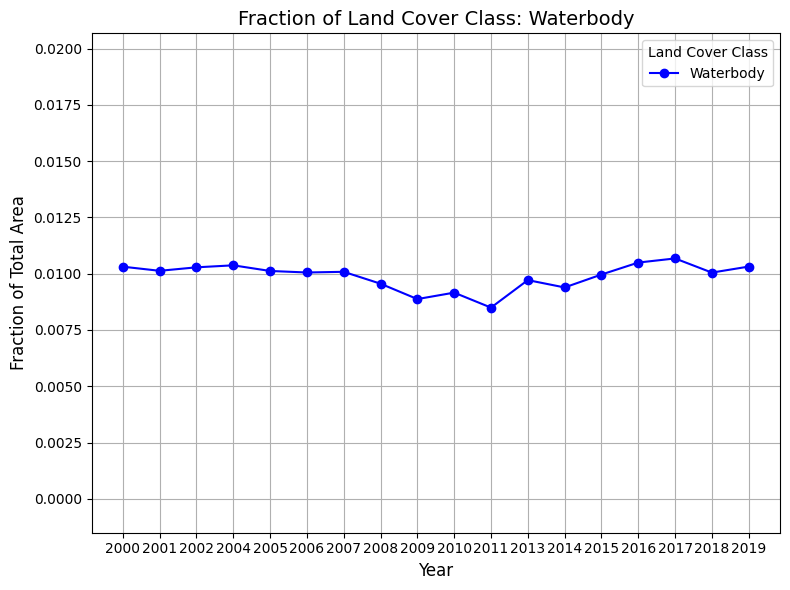

Saved plot for class 1 as /content/drive/MyDrive/Thesis/RESULT/LANDUSE/Cluster_5/land_cover_class_Waterbody.png


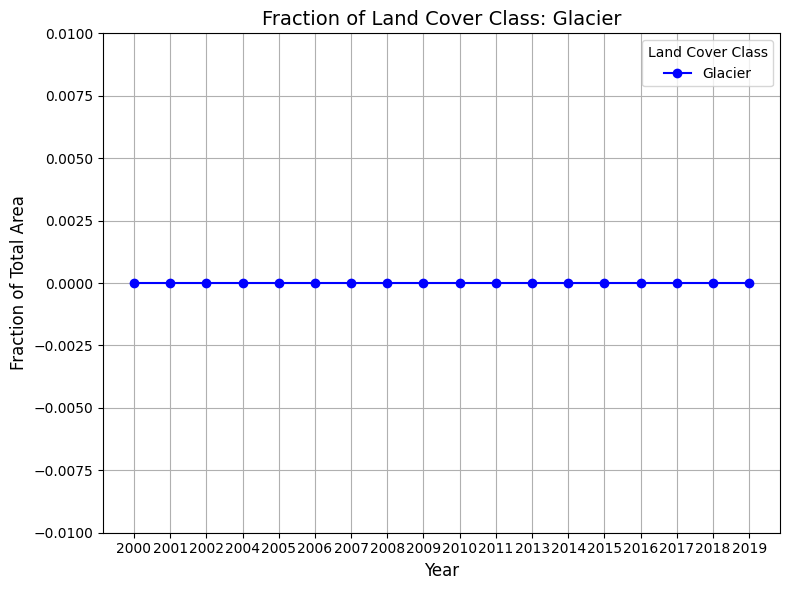

Saved plot for class 2 as /content/drive/MyDrive/Thesis/RESULT/LANDUSE/Cluster_5/land_cover_class_Glacier.png


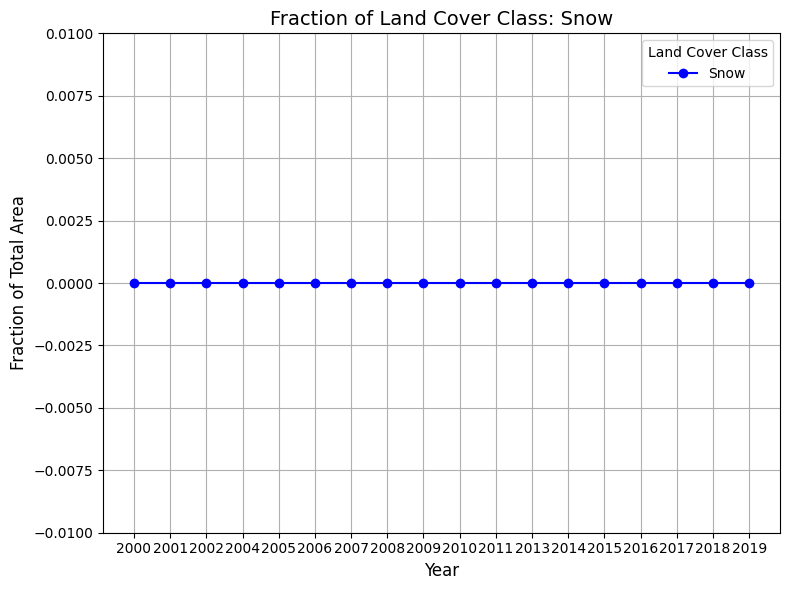

Saved plot for class 3 as /content/drive/MyDrive/Thesis/RESULT/LANDUSE/Cluster_5/land_cover_class_Snow.png


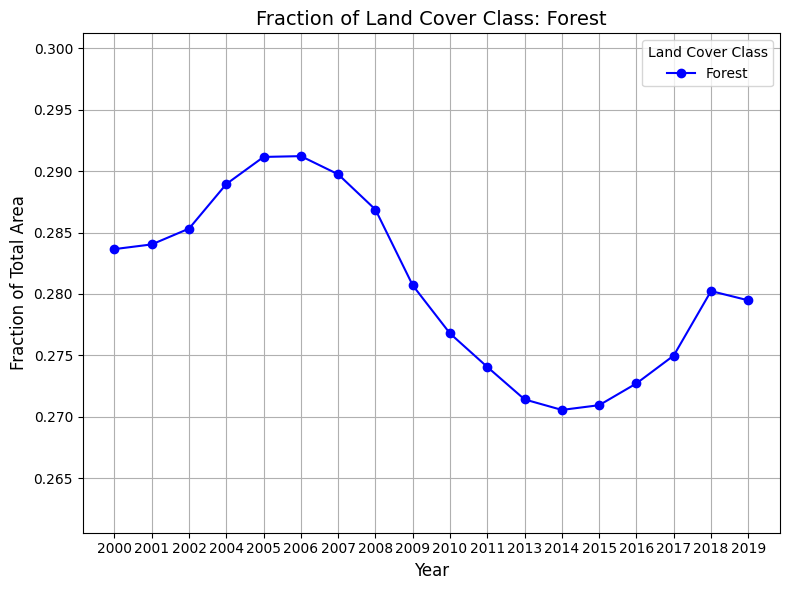

Saved plot for class 4 as /content/drive/MyDrive/Thesis/RESULT/LANDUSE/Cluster_5/land_cover_class_Forest.png


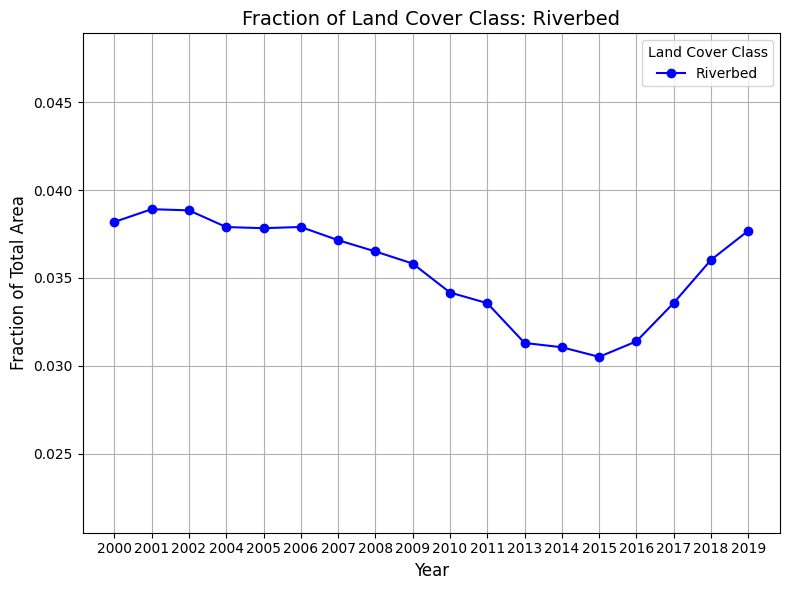

Saved plot for class 5 as /content/drive/MyDrive/Thesis/RESULT/LANDUSE/Cluster_5/land_cover_class_Riverbed.png


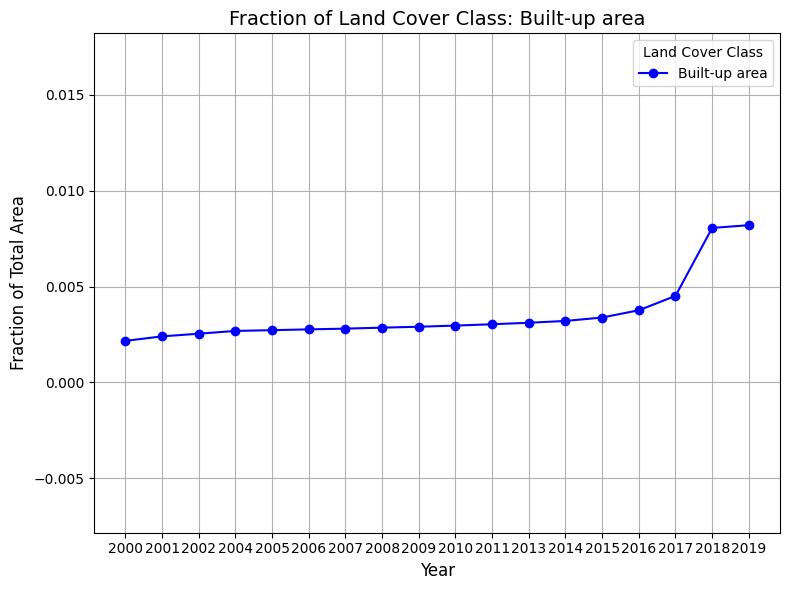

Saved plot for class 6 as /content/drive/MyDrive/Thesis/RESULT/LANDUSE/Cluster_5/land_cover_class_Built-up area.png


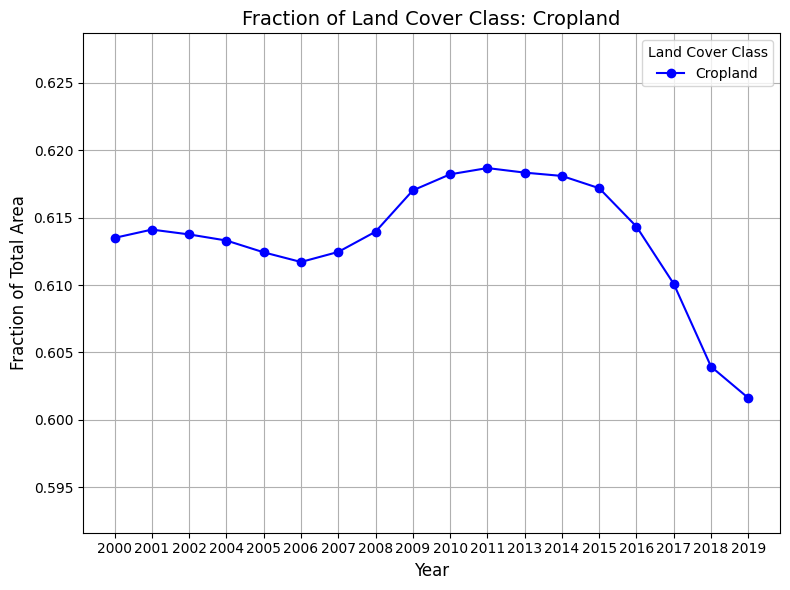

Saved plot for class 7 as /content/drive/MyDrive/Thesis/RESULT/LANDUSE/Cluster_5/land_cover_class_Cropland.png


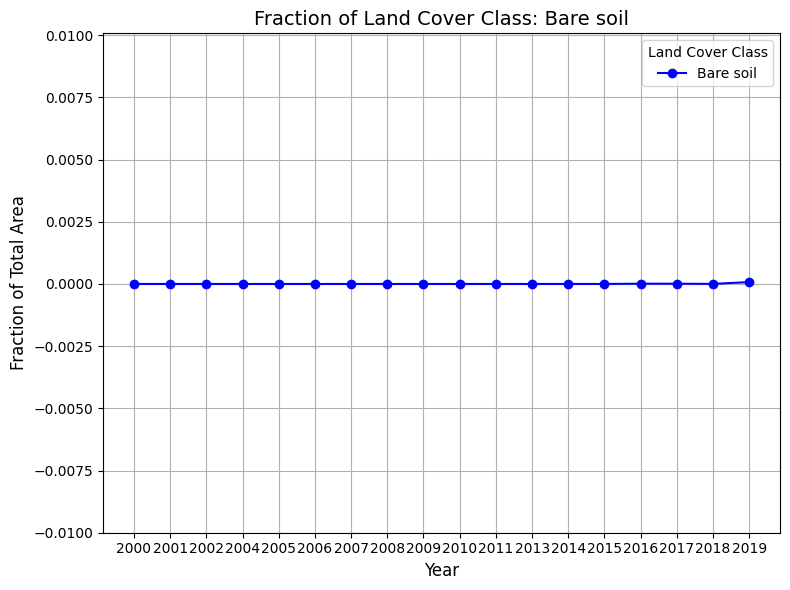

Saved plot for class 8 as /content/drive/MyDrive/Thesis/RESULT/LANDUSE/Cluster_5/land_cover_class_Bare soil.png


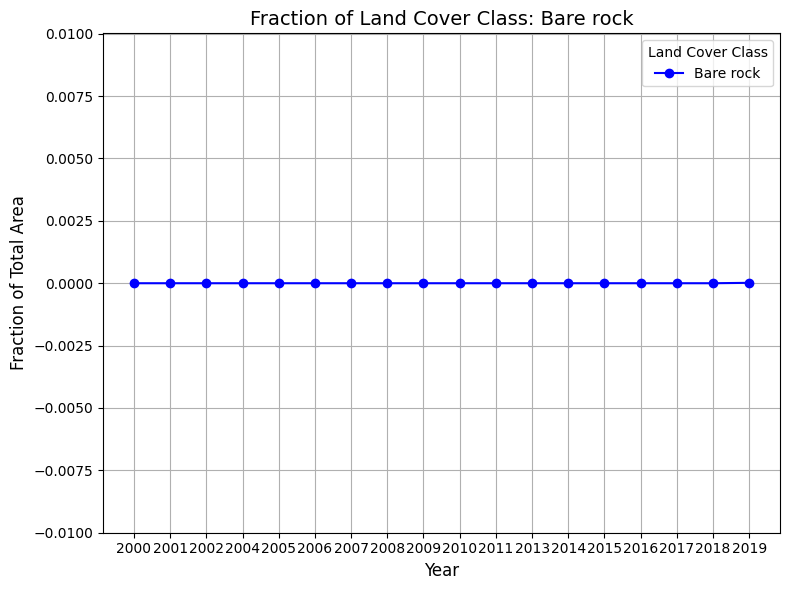

Saved plot for class 9 as /content/drive/MyDrive/Thesis/RESULT/LANDUSE/Cluster_5/land_cover_class_Bare rock.png


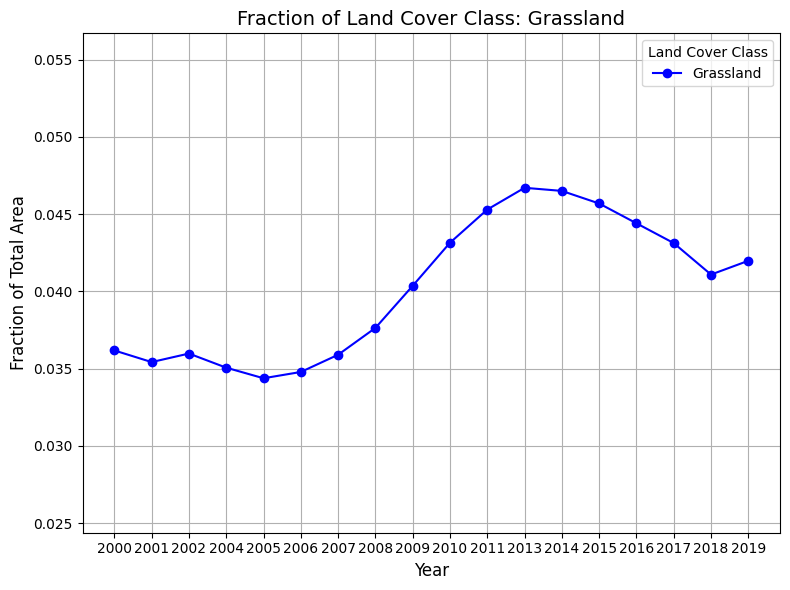

Saved plot for class 10 as /content/drive/MyDrive/Thesis/RESULT/LANDUSE/Cluster_5/land_cover_class_Grassland.png


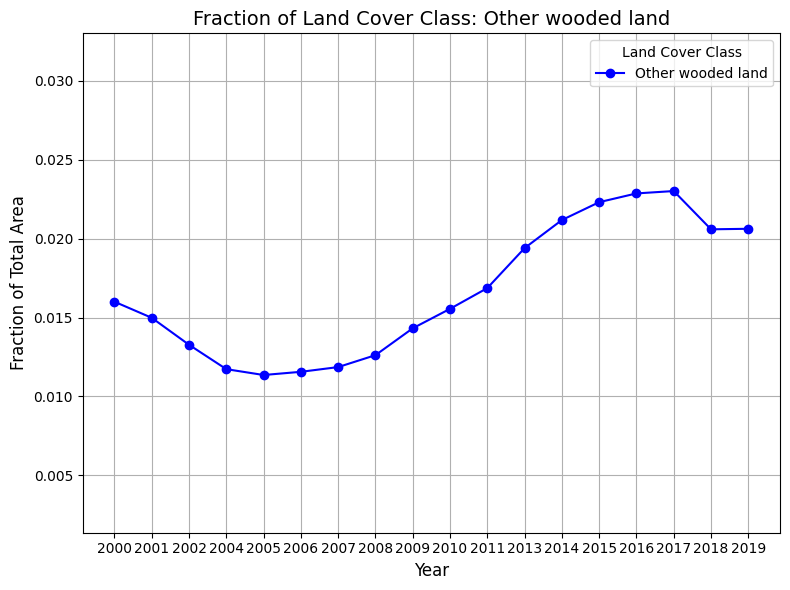

Saved plot for class 11 as /content/drive/MyDrive/Thesis/RESULT/LANDUSE/Cluster_5/land_cover_class_Other wooded land.png


In [7]:
#Land use trend for specific cluster
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# Define paths
OUT = '/content/drive/MyDrive/Thesis/REGRID/LULC Data Nepal/Output/'
shapefile_path = '/content/drive/MyDrive/Thesis/Cluster/cluster_5_2.shp'
img_path = '/content/drive/MyDrive/Thesis/RESULT/LANDUSE'
cluster = 5
output_folder = os.path.join(img_path,f"Cluster_{cluster}")
os.makedirs(output_folder,exist_ok=True)
print(output_folder)

# Load the shapefile
shapefile = gpd.read_file(shapefile_path)
shapefile = shapefile.to_crs(crs=rasterio.open(os.path.join(OUT, os.listdir(OUT)[0])).crs)  # Ensure CRS matches raster

# Extract geometry
geometry = shapefile.geometry.values

# Dictionary to store masked data
land_cover_data = {}
for tif in os.listdir(OUT):
    if tif.endswith(".tif"):
        year = tif.split("_")[-1][:-4]
        with rasterio.open(os.path.join(OUT, tif)) as src:
            # Mask the raster with the shapefile geometry
            masked_data, _ = mask(src, geometry, crop=True)
            land_cover_data[year] = masked_data[0]  # Read the first band

# Proceed with the existing analysis
years = sorted(land_cover_data.keys())
land_cover_classes = np.arange(1, 12)
fractions = {lc_class: [] for lc_class in land_cover_classes}

for year in years:
    data = land_cover_data[year]
    valid = data[data > 0]  # Exclude pixels with value 0 (no data)
    total_pixels = valid.size  # Total number of pixels in the raster
    for lc_class in land_cover_classes:
        class_pixel_count = np.sum(data == lc_class)
        fraction = class_pixel_count / total_pixels  # Calculate fraction
        fractions[lc_class].append(fraction)

# Plotting
for lc_class in land_cover_classes:
    plt.figure(figsize=(8, 6))
    fractions_class = fractions[lc_class]
    max_fraction = max(fractions_class)
    min_fraction = min(fractions_class)
    plt.plot(years, fractions_class, marker='o', linestyle='-', color='b')
    #class_name = f"Class {lc_class}"  # Replace with your land_cover_names if available
    class_name = land_cover_names.get(lc_class, f"Class {lc_class}")
    plt.title(f"Fraction of Land Cover Class: {class_name}", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Fraction of Total Area", fontsize=12)
    plt.ylim(min_fraction - 0.01, max_fraction + 0.01)
    plt.grid(True)
    plt.legend([class_name], title="Land Cover Class")
    plt.tight_layout()
    plot_filename = os.path.join(output_folder, f"land_cover_class_{class_name}.png")
    plt.savefig(plot_filename, dpi=300)  # Save with high resolution
    plt.show()
    print(f"Saved plot for class {lc_class} as {plot_filename}")

    plt.close()
